In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
import os, sys
sys.path.append('eval')
from forecast import *
torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
graph_file = 'data/graphs/400950-400951_n2.json'

cuda:1


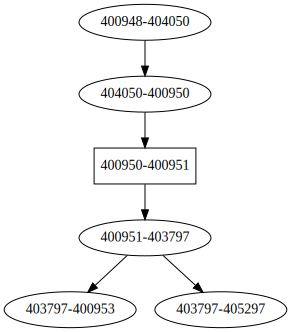

In [4]:
SROUTE, ADJ = read_graph(graph_file, 
                         verbose=False, named_adj=True)
graph = show_graph(SROUTE, ADJ)

DENSE = False
EPS = 60
# LAG = 60 + 1
LAG = 24 + 1
# LAG = 12 + 1
HSIZE = 128
STOPS = len(SROUTE)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
graph

In [5]:
SROUTE, ADJ = complete_graph(SROUTE, ADJ)

In [6]:
from models.temporal.RNN import *
from models.MPRNN import *
    
model = MPRNN(
    nodes=SROUTE, adj=ADJ, 
    hidden_size=HSIZE, 
    
    rnnmdl=RNN,
#     rnnmdl=RNN_MIN,
#     mpnmdl=MP_THIN,
    mpnmdl=MP_DENSE,
    
    verbose=True)

model.to(device)
model.device = device
model.clear_stats()


MPRNN
 [*] Defined over: 6 nodes
 [*] Contains    : 6 adjs


In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [29]:
# preview = SpotHistory(
#     SROUTE, 'train', 32, lag=LAG, res=10,
   
#     smooth=1.2,
#     ignore_missing=True,
# )
# for ii in range(20):
#     batch = preview.data[ii]
#     plt.plot(figsize=(14, 3))
#     plt.plot(batch)
#     plt.show(); plt.close()

In [10]:
dset = SpotHistory(SROUTE, 'train', 32, lag=LAG, res=10).generator()
valset = SpotHistory(SROUTE, 'test', 32, lag=LAG, res=10, shuffle=False).generator()

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [400948-404050]: 90
    * [403797-400953]: 90
    * [403797-405297]: 90
 [*] Examples (train): 5736
 [*] Time range: 2014-08-01 ~ 2014-10-31
Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [400950-400951]: 90
    * [400951-403797]: 90
    * [404050-400950]: 90
    * [400948-404050]: 90
    * [403797-400953]: 90
    * [403797-405297]: 90
 [*] Examples (test): 1455
 [*] Time range: 2014-08-01 ~ 2014-10-31


In [9]:
evf = lambda: evaluate(
    valset, model, 
    crit=lambda _y, y: criterion(_y[:, :, 0], y[:, :, 0]).item())
_ = evf()

Eval loss: 5.1602          


In [10]:
train_mse = []
eval_mse = []
eval_mape = []

In [11]:
for eii  in range(EPS):
    bls = []
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        opt.step()

        bls.append(loss.item())
        bmse = ''
        if bii == len(dset) - 1:
            bmse = (10 ** 2 * np.mean(bls))
            train_mse.append(bmse)
            bmse = '(avg %.2f)' % bmse
        sys.stdout.write('[%d/%d : %d/%d] - L%.2f %s  \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item(),
            bmse
        ))
    sys.stdout.write('\n')

    eval_mse.append(evf())
    sys.stdout.flush()
#     sch.step()

Process Process-3:
Process Process-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 104, in get
    if timeout < 0 or not self._poll(timeout):
  File "/us

KeyboardInterrupt: 

In [12]:
torch.save(model.state_dict(), 'test.pth')

In [ ]:
plt.figure(figsize=(14, 3))
plt.plot(train_mse[1:])
plt.plot(eval_mse[1:])
plt.show(); plt.close()

In [ ]:
from utils import *
testset = SpotHistory(SROUTE, 'test', 18, lag=None, res=10, shuffle=False, verbose=True)
def xfmt(datain):
    bynode = torch.split(datain.to(device).float().unsqueeze(1), 1, 2)
    return bynode

In [ ]:
model.steps = len(SROUTE)
sqerr = eval_rnn(testset, model, plot=False, xfmt=xfmt)
print('Eval segments:', len(testset))
print('Eval MSE: %.4f' % np.mean(sqerr))
# 0.0148

In [ ]:
for ii in range(5):
    _ = forecast_mprnn(
        testset[ii], model, graph_file, 
        twoway=True,
        verbose=ii is 0, plot=True)

In [ ]:
# torch.save(model, 'checkpoints/mpnn_dense_H12_L00424.pth')